# Clustering courses' descriptions through NLP and K-Means 
**Author:** Michelle Contreras-Catalán

**Professor:** Lee Spector

**Class:** COSC 247 - Machine Learning

**Term:** Spring 2023

The objective of this project is to use the Python package nltk (widely used for natural language processing) to cluster the courses offered during Fall 2023 at Amherst College based on their description (usually ~2 paragraphs). The idea is to analyze what classes are clustered together by the model and compare how they align with their respective department.

Moreover, it would be interesting to analyze whether there are some outliers when visualizing these clusters, and if so, why is that happening? Can future courses from incoming professors "diversify" our current catalogue?
### Install and import libraries

In [ ]:
# Install external libraries
pip install mpld3
pip install nltk
pip install spacy
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [1]:
# Import functions and libraries
import numpy as np
import pandas as pd
import nltk
import joblib
import matplotlib.pyplot as plt
import re
from matplotlib import figure
from sklearn.cluster import KMeans
import string
import seaborn as sns
import matplotlib as plt
import spacy
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import mpld3

### Import the data

In [2]:
classes = pd.read_csv('classes_norepeats.csv', low_memory = False, encoding='utf-8')
# preview the data
classes

,Academic Period,Academic Level,Instructional Method,Course Subjects,Section,Course Definition,Abbreviated Title,Description,All Instructors,Enrollment Count,...,Section Details,Locations,Meeting Patterns,Meeting Day Patterns,Start Time,End Time,Subject,Course Number,Section Number,Hidden Course Section
0,Fall 2023,Undergraduate,Lecture,American Studies,AMST 111-02 - Global Valley,AMST 111 - Global Valley,Global Valley,[Pre-1900] Drawing on a wide range of primary ...,Karen Sanchez-Eppler,4,...,Tuesday/Thursday | 10:00 AM - 11:20 AM,NaN,Tuesday/Thursday | 10:00 AM - 11:20 AM,Tuesday/Thursday,07:00,08:20,American Studies,111,02,NaN
1,Fall 2023,Undergraduate,Lecture,American Studies\n\nBlack Studies,AMST 130-01/ BLST 130-01 - Transnational America,AMST 130/ BLST 130 - Transnational America,Transnational America,(Offered as AMST 130 and BLST 130[D]) The hust...,Jallicia Jolly,4,...,Tuesday/Thursday | 1:00 PM - 2:20 PM,NaN,Tuesday/Thursday | 1:00 PM - 2:20 PM,Tuesday/Thursday,10:00,11:20,American Studies,130,01,NaN
2,Fall 2023,Undergraduate,Lecture,American Studies,AMST 205-01 - Sports in America,AMST 205 - Sports in America,Sports in America,Sports infiltrate American lives. Whether we ...,Robert Hayashi,13,...,Tuesday/Thursday | 2:30 PM - 3:50 PM,NaN,Tuesday/Thursday | 2:30 PM - 3:50 PM,Tuesday/Thursday,11:30,12:50,American Studies,205,01,NaN
3,Fall 2023,Undergraduate,Lecture,American Studies,"AMST 217-01 - Religion, Democracy","AMST 217 - Religion, Democracy","Religion, Democracy",[Pre-1900] The United States has inscribed the...,Francis Couvares,7,...,Tuesday/Thursday | 8:30 AM - 9:50 AM,NaN,Tuesday/Thursday | 8:30 AM - 9:50 AM,Tuesday/Thursday,05:30,06:50,American Studies,217,01,NaN
4,Fall 2023,Undergraduate,Lecture,American Studies,AMST 219-01 - Rebels and Reformers:,AMST 219 - Rebels and Reformers:,Rebels and Reformers:,This course examines the experiences of women ...,Wendy Bergoffen,1,...,Tuesday/Thursday | 1:00 PM - 2:20 PM,NaN,Tuesday/Thursday | 1:00 PM - 2:20 PM,Tuesday/Thursday,10:00,11:20,American Studies,219,01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,Fall 2023,Undergraduate,Lecture,Theater and Dance,THDA 315H-01 - Dance: Adv. Contemporary,THDA 315H - Dance: Adv. Contemporary,Dance: Adv. Contemporary,This is an advanced-level course in contempora...,Jenna Riegel,2,...,Tuesday/Thursday | 4:00 PM - 5:20 PM,NaN,Tuesday/Thursday | 4:00 PM - 5:20 PM,Tuesday/Thursday,13:00,14:20,Theater and Dance,315H,01,NaN
508,Fall 2023,Undergraduate,Lecture,Theater and Dance,THDA 340-01 - Acting/Directing Studio,THDA 340 - Acting/Directing Studio,Acting/Directing Studio,This is a studio course in collaboration leadi...,Ron Bashford,5,...,Monday/Wednesday | 2:00 PM - 3:50 PM,NaN,Monday/Wednesday | 2:00 PM - 3:50 PM,Monday/Wednesday,11:00,12:50,Theater and Dance,340,01,NaN
509,Fall 2023,Undergraduate,Lecture,Theater and Dance,THDA 400H-01 - Production Studio,THDA 400H - Production Studio,Production Studio,A course in integrating previously studied ski...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Theater and Dance,400H,01,NaN
510,Fall 2023,Undergraduate,Lecture,Theater and Dance,THDA 490-01 - Special Topics (Special Topics),THDA 490 - Special Topics,Special Topics,Independent reading course.\nAdmission with co...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Theater and Dance,490,01,NaN


In [4]:
# make sure descriptions are being passed as strings
classes["Description"] = classes["Description"].astype(str)

## Stopwords, stemming, and tokenizing
As part of the "cleaning" process, we must remove **stopwords** from our data. Stopwords are considered as filler words in our dataset, for example: how, is, and, are, among others are considered stopwords. The nltk library provides a set of stopwords that will be removed from our descriptions.

Similarly, we must stem our words and consider only their roots, i.e. love and loved will be considered as the same word.

Lastly, we have to tokenize our descriptions so that our model can have a vocabulary to work with.

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# define a tokenizer and stemmer 

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
# make sure we don't have any line breaks \n 
classes = classes.replace(r'\n',' ', regex=True) 

In [9]:
# store stems
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in classes["Description"]:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
# store the "new vocabulary", i.e. the stemmed words    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [10]:
print(vocab_frame)

             words
pre-1900  pre-1900
draw       drawing
on              on
a                a
wide          wide
...            ...
class        class
may            may
also          also
be              be
requir    required

[86102 rows x 1 columns]


Now, we will use Tfidf to vectorize our words. At the end, each one of the descriptions will represent a numerical value, more specifically, a vector.

The details of how Tfidf works are the following:

* **Term Frequency (TF):** It measures how many times a specific word appears in a description.

* **Inverse Document Frequency (IDF):** It measures how "important" a word is; if a word appears less times, it will be treated as more important.

Lastly, we combine multiply these two values to obtain the TF-IDF. This score represents how relevant a word is in the entire corpus (the vocabulary).

In [11]:
# running this code raises a warning, which is due to stopwords being stemmed. From what I read this shouldn't cause
# any major issues

from sklearn.feature_extraction.text import TfidfVectorizer

# Now, we will create the tfidf matrix. In short terms, what this does is analyzing the frequency of the words among 
# all descriptions of classes in the dataseet
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(classes["Description"])
terms = tfidf_vectorizer.get_feature_names_out()
dist = 1 - cosine_similarity(tfidf_matrix)

/Users/michellecontreras/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


# K-Means
Now that we have tokenized our data, created the tfidf matrix and calculated the distances, we will peform k-means, which is an unsupervised machine learning algorithm to cluster data into different groups.

We will decide the number of clusters using the elbow method, which basically takes the sum of the squared distances and compares how this behaves with different numbers of clusters. In short terms, we need to find the lowest squared distance possible to have a "good" number of clusters. 

In [12]:
# caclulate squared distances 
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(init="k-means++", n_clusters=k, random_state=345)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)

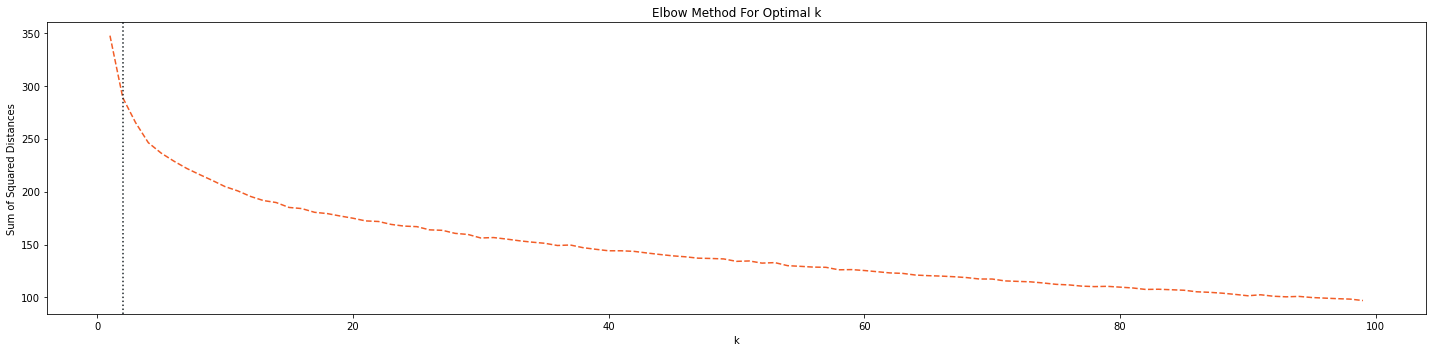

In [13]:
# plot the squared distances
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)

ax.lines[0].set_linestyle("--")
ax.lines[0].set_color("#F25D27")

# Add a vertical line to show the optimum number of clusters
plt.axvline(2, color='#1A2226', linestyle=':')

plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')

plt.tight_layout()
plt.savefig('textclustering_elbow.png', dpi=300)
plt.show();

We can see that how around a hundred clusters we reach a sum of squared distances around 100-150. Although this is not optimal, going over a hundred clusters is probably not a good idea, as we only have around 40 departments. 

In [14]:
# define our "k" as a 100 
num_clusters = 100

# IMPORTANT: we must define a random state since given that the clusters can vary every time we run the code; for this
# project I chose the random state 345 and will continue using it throughout the notebook
km = KMeans(n_clusters=num_clusters, random_state = 345)

%time km.fit(tfidf_matrix)

# convert clusters to list and insert into our classes dataframe

clusters = km.labels_.tolist()

kmeans_labels = pd.DataFrame(clusters)

classes.insert((classes.shape[1]),'clusters',kmeans_labels)

CPU times: user 2.79 s, sys: 615 ms, total: 3.4 s
Wall time: 580 ms


## Silhouette score
To measure the quality of the clusters, we will use the silhoutte score. 

In [15]:
from sklearn.metrics import silhouette_score
def get_silhouette_score(tfidf_matrix, k):
    for n_clusters in range(2, k):
        clusterer = KMeans(init="k-means++", n_clusters=n_clusters, random_state=345)
        y = clusterer.fit_predict(tfidf_matrix)

        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, silhouette_score(tfidf_matrix, y)))
        
get_silhouette_score(tfidf_matrix, 150)

For n_clusters = 2 The average silhouette_score is: 0.1671446253111833
For n_clusters = 3 The average silhouette_score is: 0.1506774970920416
For n_clusters = 4 The average silhouette_score is: 0.16352662818511138
For n_clusters = 5 The average silhouette_score is: 0.150026979498466
For n_clusters = 6 The average silhouette_score is: 0.13263597696194004
For n_clusters = 7 The average silhouette_score is: 0.13766148841924095
For n_clusters = 8 The average silhouette_score is: 0.13569844733945938
For n_clusters = 9 The average silhouette_score is: 0.13603092197892125
For n_clusters = 10 The average silhouette_score is: 0.14640814997841275
For n_clusters = 11 The average silhouette_score is: 0.14101611097775116
For n_clusters = 12 The average silhouette_score is: 0.1451560962882218
For n_clusters = 13 The average silhouette_score is: 0.15317639751224757
For n_clusters = 14 The average silhouette_score is: 0.14849633669372847
For n_clusters = 15 The average silhouette_score is: 0.154653396

In [16]:
# get counts for the clusters
classes['clusters'].value_counts()

4     31
66    17
26    16
52    15
49    15
      ..
50     2
8      2
45     2
77     2
97     1
Name: clusters, Length: 100, dtype: int64

As seen above, the average silhoute score we get around 100-150 clusters, is just about ~0.2, which is objectively not good. However, given the nature of the data used for this project, it should not matter **that much** since different classes can overlap with content from other areas. Therefore, we will move on and keep in mind that given other random_state the cluster might look very different since our silhoutte score is not the best.

In my write-up document I commented that it might be a good idea to also try soft clustering to see how a class can move around different clusters. 

## Analysis by department
Here, I will generate count plots for some departments to analyze the clusters generated among each of them. A more thorough analysis of this can be found in the write-up docunent

### Mathematics

In [18]:
# drop irrelevant columns
classes = classes[['Course Subjects', 'Course Definition', 'clusters']]
classes

,Course Subjects,Course Definition,clusters
0,American Studies,AMST 111 - Global Valley,41
1,American Studies Black Studies,AMST 130/ BLST 130 - Transnational America,41
2,American Studies,AMST 205 - Sports in America,59
3,American Studies,"AMST 217 - Religion, Democracy",82
4,American Studies,AMST 219 - Rebels and Reformers:,85
...,...,...,...
507,Theater and Dance,THDA 315H - Dance: Adv. Contemporary,20
508,Theater and Dance,THDA 340 - Acting/Directing Studio,20
509,Theater and Dance,THDA 400H - Production Studio,20
510,Theater and Dance,THDA 490 - Special Topics,69


In [19]:
# function to locate specific department within the dataframe
def dept_locate(dept):
    return classes.loc[classes['Course Subjects'] == dept]

In [20]:
# filter math classes
math = dept_locate("Mathematics")
math

,Course Subjects,Course Definition,clusters
326,Mathematics,MATH 105 - Calculus with Algebra,31
327,Mathematics,MATH 111 - Intro to the Calculus,24
328,Mathematics,MATH 121 - Intermediate Calculus,24
330,Mathematics,MATH 211 - Multivariable Calculus,24
331,Mathematics,MATH 220 - Mathematical Reasoning,24
332,Mathematics,MATH 256 - Combinatorial Geometry,83
333,Mathematics,MATH 260 - Differential Equations,83
334,Mathematics,MATH 271 - Linear Algebra,24
335,Mathematics,MATH 272 - Linear Algebra W Applica,24
336,Mathematics,MATH 280 - Graph Theory,83


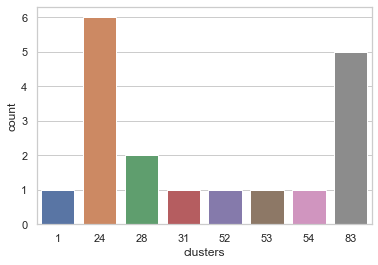

In [21]:
# function to create count plot
def count_plot(dept):
    sns.set_theme(style="whitegrid")
    dept_plot = sns.countplot(x = dept["clusters"])
    fig_dept = dept_plot.get_figure()
    # fig_dept.savefig("dept_clusters.png") 
    plt.show()
    
count_plot(math)

In [22]:
# used to get the classes from each cluster (used in report)
def get_cluster(cluster):
    dept = classes.loc[classes['clusters'] == cluster]
    return dept["Course Definition"]

# take a look at cluster 24
get_cluster(24)    

163       ECON 111 - An Intro to Economics
327       MATH 111 - Intro to the Calculus
328       MATH 121 - Intermediate Calculus
330      MATH 211 - Multivariable Calculus
331      MATH 220 - Mathematical Reasoning
334              MATH 271 - Linear Algebra
335    MATH 272 - Linear Algebra W Applica
483              SPAN 490 - Special Topics
Name: Course Definition, dtype: object

In [23]:
# take a look at cluster 28
get_cluster(28)    

340    MATH 350 - Groups, Rings and Fields
341           MATH 355 - Intro to Analysis
Name: Course Definition, dtype: object

In [24]:
# take a look at cluster 83
get_cluster(83)    

174      ECON 361 - Advanced Econometrics
332     MATH 256 - Combinatorial Geometry
333     MATH 260 - Differential Equations
336               MATH 280 - Graph Theory
337    MATH 315 - Comp Algebraic Geometry
343     MATH 460 - Analytic Number Theory
Name: Course Definition, dtype: object

### Computer Science

In [25]:
# filter cs classes
cs = dept_locate("Computer Science")
cs

,Course Subjects,Course Definition,clusters
151,Computer Science,COSC 111 - Intro Comp Science I,94
152,Computer Science,COSC 112 - Intro Comp Science II,45
153,Computer Science,COSC 112L - Intro CompSci II Lab,45
154,Computer Science,COSC 211 - Data Structures,71
155,Computer Science,COSC 241 - Artificial Intelligence,2
156,Computer Science,COSC 257 - Databases,25
157,Computer Science,COSC 265 - Computing Hardware,91
158,Computer Science,COSC 283 - Networks,51
159,Computer Science,COSC 311 - Algorithms,71
160,Computer Science,COSC 390 - Special Topics,26


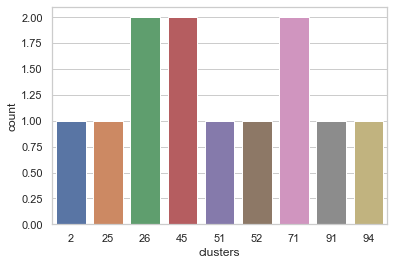

In [26]:
# create count plot
count_plot(cs)

In [27]:
# used to get the classes from each cluster (used in report)
get_cluster(45) 

152    COSC 112 - Intro Comp Science II
153    COSC 112L - Intro CompSci II Lab
Name: Course Definition, dtype: object

In [28]:
get_cluster(71)

154       COSC 211 - Data Structures
159            COSC 311 - Algorithms
262       GEOL 401 - Plate Tectonics
423              PHYS 343 - Dynamics
425    PHYS 460 - General Relativity
Name: Course Definition, dtype: object

### English

In [29]:
eng = dept_locate("English")
eng

,Course Subjects,Course Definition,clusters
191,English,ENGL 125 - Representing Illness,82
194,English,ENGL 192 - Female Friendship,81
195,English,ENGL 219 - Hybrid Forms,62
196,English,ENGL 221 - Writing Poetry I,81
197,English,ENGL 224 - Creative Nonfiction,62
198,English,ENGL 226 - Fiction Writing I,84
199,English,ENGL 238 - Shakespeare,47
200,English,ENGL 240 - Reading Poetry,29
202,English,ENGL 270 - Letter Writers,65
205,English,ENGL 291 - AAPI Critiques,59


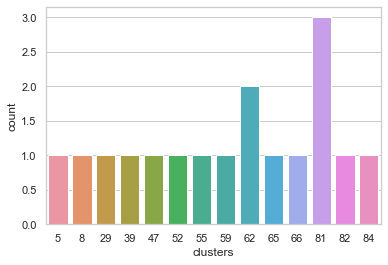

In [30]:
# get countplot for English
count_plot(eng)

In [31]:
# let's take a look at the most poular cluster in the English department
get_cluster(81)

192    ENGL 171/ THDA 170 - Intro to Playwriting
194                 ENGL 192 - Female Friendship
196                  ENGL 221 - Writing Poetry I
207           ENGL 304 - Narratives of Suffering
Name: Course Definition, dtype: object

## Visualization of the cluster
Now, we will visualize the cluster (all ~500 classes) 

In [32]:
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [36]:
# create an array to visualize the plot
import numpy as np
lst = np.arange(0,100).tolist()  

In [37]:
# each cluster will have its own color, which we have generated at random 
cluster_colors = {}
values = ["#828174", "#a600f1", "#7aff79", "#2000c5", "#ffcb00", "#4900b2", "#3b9800", "#ff51ff", "#008f2a", "#a209bc", "#79e07e", "#005fff", "#cea300", "#0061f9", "#ffb035", "#000063", "#ffff9b", "#790089", "#1dab54", "#9f009a", "#00a85c", "#ff5fd0", "#006c0e", "#ff78ef", "#0c6000", "#d28aff", "#026b18", "#f80000", "#00ff3f", "#ff3800", "#00ffff", "#cd0025", "#00ffff", "#ac0000", "#00f8ff", "#c02400", "#00eeff", "#9a0000", "#00daff", "#b12e00", "#006fe4", "#737a00", "#003ea3", "#93cc7b", "#00328e", "#297b24", "#5491ff", "#005000", "#ab2074", "#82c176", "#00287c", "#ffcf87", "#0050a0", "#ff7b4e", "#00adff", "#b52b2a", "#00dcf0", "#650000", "#00c7ff", "#870031", "#00c0de", "#bc3f4a", "#00bdff", "#7e5800", "#00a3f8", "#004b00", "#e672b6", "#004500", "#ffc2ff", "#002905", "#ffe2ff", "#1b1900", "#cfc2ff", "#344f00", "#cacdff", "#470000", "#6ed1ff", "#7c291b", "#00bbe9", "#ff8982", "#008b70", "#ff98b0", "#003c2d", "#ebd1a3", "#512f71", "#2e3400", "#8fdaff", "#433000", "#007aab", "#645229", "#00407a", "#aa6061", "#008f93", "#bf709e", "#003933", "#6a87b6", "#005265", "#004672", "#406785", "#004765", "#008765"]
for i in lst:
    cluster_colors[i] = values[i]

We will crete a plot with no lengeds (will raise a warning, but we can ignore it), as they would represent each cluster and given that we have 100 of them, the box for it would be too big. However, we will keep the name of the departments next to each point, but we will note that this visualization is not quite convenient.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


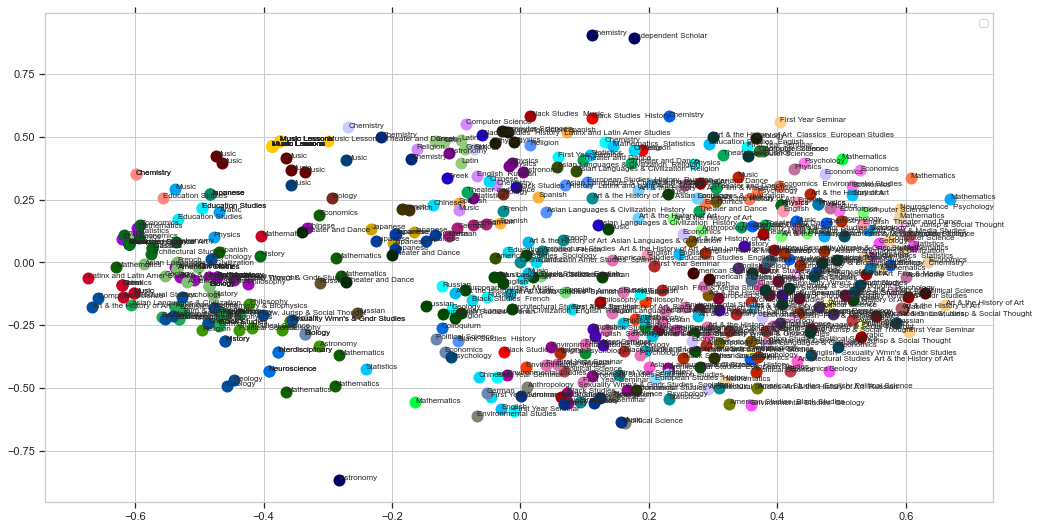

In [38]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
%matplotlib inline
df = pd.DataFrame(dict(x=xs, y=ys, label=classes["clusters"], title=classes["Course Subjects"])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# add label in x,y position with the label as the department 
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
# label=cluster_names[name],
    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Interactive visualization
As the prior attempt to visualize the cluster was not the best, we will instead create an interactive visualization. Same color will represent same cluster, although given that we have 100 clusters, we will have 100 colors total.

Both functions are slightly modified versions from: http://brandonrose.org/top100

In [39]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 120);
      this.fig.toolbar.toolbar.attr("y", 600);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [40]:
#create data frame that has the result of the MDS plus the cluster numbers and course name
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=classes["Course Definition"])) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

svg.mpld3-figure {
margin-left: -50px;}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(16,10)) #set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
# ax.legend(numpoints=1, borderpad=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)

## Predicting clusters
Lastly, we will use scikit's predict function to see where, given a description of a new class (in this case, we will use classes that are not offered next year), where would it fit in the cluster. Is it actually related to those who were mapped to that same cluster? For more details of this analysis, please read the write-up document.

In [41]:
# load the descriptions
hstem = ["This is an interactive course that combines academic inquiry and community engagement to investigate the theme of diversity within STEM fields--at Amherst and beyond. In the first half of the semester we ground our understanding of the STEM experience at Amherst in national and global contexts, specifically looking at the way in which gender, class, race, sexuality, and geographic upbringing might shape these experiences. We accomplish this through reading interdisciplinary scholarly literature and surveying existing evidence-based inclusive practices at a range of educational institutions. We will supplement this research with interviews with current and past members of the Amherst STEM community. In the second half of the semester, students will design their own group projects that apply the findings of their research to develop resources and engage the STEM community, whether at the college, local, or national level.  Course work includes weekly readings, reflective writing, in-class discussion, and will culminate in a public presentation on the group projects."]
thinkingcs = ["Analytical thinking is inherent in every aspect of computer science. We need to be able to answer questions such as: how do I know that my program works correctly? How efficient is my approach to solving a problem? How does human-readable code get translated into something that can run on physical hardware? What problems are even solvable by computers? In order to study such questions, computer scientists must be able to communicate with one another using a common language, express ideas formally and precisely, and reason logically about these ideas. This course will introduce mathematics as the primary analytical tool used by computer scientists. Topics may include but are not limited to set notation, symbolic logic, proof techniques such as induction and contradiction, and applications of these topics in computer science. Much more important than any individual topic, however, is the experience that students will gain with formal reasoning."]
voting = ["The outcomes of many elections, whether to elect the next United States president or to rank college football teams, can displease many of the voters. How can perfectly fair elections produce results that nobody likes? We will analyze different voting systems, including majority rule, plurality rule, Borda count, and approval voting, and assess a voter’s power to influence the election under each system, for example, by calculating the Banzhaf power index. We will prove Arrow’s Theorem and discuss its implications. After exploring the pitfalls of various voting systems through both theoretical analysis and case studies, we will try to answer some pressing questions: Which voting system best reflects the will of the voters? Which is least susceptible to manipulation? What properties should we seek in a voting system, and how can we best attain them?"]
# vectorize the descriptions and predict
pred = km.predict(tfidf_vectorizer.transform(hstem))
pred2= km.predict(tfidf_vectorizer.transform(thinkingcs))
pred3= km.predict(tfidf_vectorizer.transform(voting))

# print results
print("Human in STEM cluster: ", pred)
print("Thinking like a computer scientist cluster: ", pred2)
print("Lnaguage learning and globalization cluster: ", pred3)

Human in STEM cluster:  [85]
Thinking like a computer scientist cluster:  [7]
Lnaguage learning and globalization cluster:  [86]


In [42]:
# function to preview a specific 
def get_cluster(num):
    return classes.loc[classes["clusters"] == num]

In [43]:
# get cluster for being human in stem
get_cluster(85)

,Course Subjects,Course Definition,clusters
4,American Studies,AMST 219 - Rebels and Reformers:,85
176,Economics,ECON 412 - Pluralist Applied Micro,85


In [44]:
# get cluster for thinking like a computer scientist
get_cluster(7)

,Course Subjects,Course Definition,clusters
221,Environmental Studies Geology,ENST 253/ GEOL 253 - Geospatial Inquiry,7
258,Geology,GEOL 105 - Oceanography,7
261,Geology,GEOL 271 - Mineralogy,7
342,Mathematics Statistics,MATH 360/ STAT 360 - Probability,7
488,Statistics,STAT 225 - Nonparametric Statistics,7


In [45]:
get_cluster(86)

,Course Subjects,Course Definition,clusters
232,European Studies History,EUST 344/ HIST 344 - Empires in Global Hist,86
288,History,HIST 427 - Citizenship in Empire,86


# References
A more thorough list of references can be found in the write-up document, but this notebook was highly inspired by Brandon Rose, who clustered different movies based on their description. http://brandonrose.org/top100